In [1]:
""" 
We will use subversion to get only 1 folder from our github repo, 
instead of cloning the entire repository using git.clone
(Done by replacing ".../tree/main/S7" with ".../trunk/S7")
"""

!apt install subversion
!svn checkout https://github.com/AkhilP9182/EVA5---Extensive-Vision-AI/trunk/S7
!svn update S7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
UU   S7/utilities.py
Checked out revision 103.
Updating 'S7':
At revision 103.


In [2]:
""" Our folder S7 (which contains all the required files) has been downloaded into the root folder"""
%ls

data/  S7/  sample_data/


In [3]:
import os
folder_name = "S7/"
print("Python files in the folder {}".format(folder_name))
for root, dirs, files in os.walk(folder_name):
    for filename in files:
        if (".py" in filename and ".pyc" not in filename):
            print(filename)

Python files in the folder S7/
config.py
layers.py
model.py
train_test.py
utilities.py


We can see that all the required files have been downloaded

### **Importing required packages**

In [4]:
# Importing the necessary packages
import sys
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importing the custom classes and functions
import S7.utilities as util
import S7.config as config
from S7.model import Net
from S7.train_test import train,test

### **Load Train/Test datasets (with the new mean and std deviation normalization)**

#### Calculate mean and std. deviation of combined (train+test) data

In [6]:
SEED = 1  # Set Randomization seed for Reproducible results
torch.manual_seed(SEED)                 

if config.USE_CUDA:
    torch.cuda.manual_seed(SEED)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = config.to_tensor)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = config.to_tensor)

mean_cifar10, std_cifar10 = util.get_mean_std_overall(trainset,testset)

mean_cifar10 = tuple(mean_cifar10.numpy())
std_cifar10 = tuple(std_cifar10.numpy())

print("\nChannelwise Mean of overall CIFAR 10 dataset:\t\t\t{}".format(mean_cifar10))  # mean_cifar10 = (0.49186122, 0.48266134, 0.44720834)
print("Channelwise Standrad Deviation of overall CIFAR 10 dataset:\t{}\n".format(std_cifar10)) # std_cifar10 = (0.24699295, 0.24340236, 0.26160896)

util.dataset_info(trainset,testset)

Files already downloaded and verified
Files already downloaded and verified

Channelwise Mean of overall CIFAR 10 dataset:			(0.49186122, 0.48266134, 0.44720834)
Channelwise Standrad Deviation of overall CIFAR 10 dataset:	(0.24699295, 0.24340236, 0.26160896)

Number of classes in CIFAR10   : 10
Number of images for training  : 50000
Number of images for validation: 10000


'Data loading done!'

#### Use loader function to make a loader iterator

In [7]:
# del trainset,testset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = config.train_transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = config.test_transform)

train_loader  = util.train_loader_cifar10(trainset, mean = mean_cifar10, std = std_cifar10)
test_loader   = util.test_loader_cifar10(testset,  mean = mean_cifar10, std = std_cifar10)
classes = config.CIFAR_classes
print(classes)
num_classes = len(classes)
print("\nNumber of classes = {}".format(num_classes))

Files already downloaded and verified
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of classes = 10


### **Plot some images from test set**

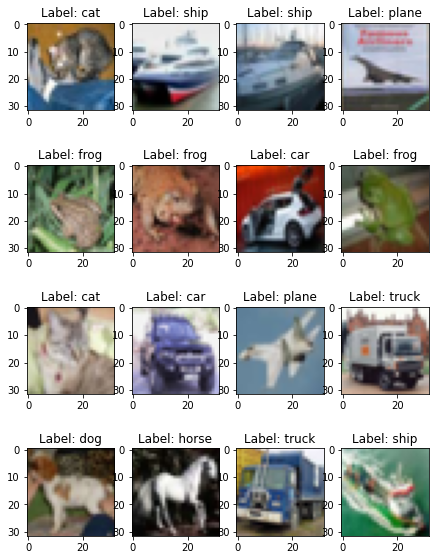

In [8]:
util.plot_images(test_loader, rows=4, cols=4, mean = mean_cifar10, std=(std_cifar10), classes = list(config.CIFAR_classes))

## **Model Summary**

In [9]:
device = config.DEVICE   # Selects whether to run the model on GPU or CPU
model = Net(BN_type="BN").to(device)                # Loads the model weights on the gpu or cpu
summary(model, input_size=config.input_size_CIFAR10)  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 28, 28]          73,728
      BatchNorm2d-10          [-1, 128, 28, 28]             256
             ReLU-11          [-1, 128, 28, 28]               0
          Dropout-12          [-1, 128, 28, 28]               0
        MaxPool2d-13          [-1, 128, 14, 14]               0
           Conv2d-14           [-1, 32,

## **Training and Testing the model**

In [16]:
epochs = config.EPOCHS             # No. of training epochs

train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

optimizer = optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = config.LR_STEP, gamma=config.LR_GAMMA)

max_test_acc = 0
for epoch in range(0, epochs):
    train_loss,train_acc = train(model, config.DEVICE, train_loader, optimizer, epoch, L2_param = 0.001)
    test_loss,test_acc   = test(model, config.DEVICE, test_loader)
    if (test_acc > max_test_acc): # Save the best performing model
        model_path = 'S7/models/S7_best_model.model'
        torch.save(model.state_dict(), model_path)
        max_test_acc = test_acc
    scheduler.step()       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.001
Train Set: Mean loss: 1.1844, Train Accuracy: 29106/50000 (58.21%)
Test Set : Mean loss: 1.1658, Test Accuracy : 5888/10000 (58.88%)




Epoch:1 Learning Rate:0.001
Train Set: Mean loss: 1.0629, Train Accuracy: 31429/50000 (62.86%)
Test Set : Mean loss: 1.0490, Test Accuracy : 6363/10000 (63.63%)




Epoch:2 Learning Rate:0.001
Train Set: Mean loss: 0.9055, Train Accuracy: 33554/50000 (67.11%)
Test Set : Mean loss: 0.9063, Test Accuracy : 6709/10000 (67.09%)




Epoch:3 Learning Rate:0.001
Train Set: Mean loss: 0.8873, Train Accuracy: 34122/50000 (68.24%)
Test Set : Mean loss: 0.8974, Test Accuracy : 6799/10000 (67.99%)




Epoch:4 Learning Rate:0.001
Train Set: Mean loss: 0.7598, Train Accuracy: 36543/50000 (73.09%)
Test Set : Mean loss: 0.7793, Test Accuracy : 7223/10000 (72.23%)




Epoch:5 Learning Rate:0.0008
Train Set: Mean loss: 0.7021, Train Accuracy: 37608/50000 (75.22%)
Test Set : Mean loss: 0.7393, Test Accuracy : 7393/10000 (73.93%)




Epoch:6 Learning Rate:0.0008
Train Set: Mean loss: 0.6554, Train Accuracy: 38289/50000 (76.58%)
Test Set : Mean loss: 0.7231, Test Accuracy : 7476/10000 (74.76%)




Epoch:7 Learning Rate:0.0008
Train Set: Mean loss: 0.6353, Train Accuracy: 38799/50000 (77.60%)
Test Set : Mean loss: 0.6819, Test Accuracy : 7630/10000 (76.30%)




Epoch:8 Learning Rate:0.0008
Train Set: Mean loss: 0.6165, Train Accuracy: 39150/50000 (78.30%)
Test Set : Mean loss: 0.6760, Test Accuracy : 7614/10000 (76.14%)




Epoch:9 Learning Rate:0.0008
Train Set: Mean loss: 0.6502, Train Accuracy: 38668/50000 (77.34%)
Test Set : Mean loss: 0.7248, Test Accuracy : 7564/10000 (75.64%)




Epoch:10 Learning Rate:0.00064
Train Set: Mean loss: 0.5374, Train Accuracy: 40475/50000 (80.95%)
Test Set : Mean loss: 0.6206, Test Accuracy : 7849/10000 (78.49%)




Epoch:11 Learning Rate:0.00064
Train Set: Mean loss: 0.5755, Train Accuracy: 39837/50000 (79.67%)
Test Set : Mean loss: 0.6356, Test Accuracy : 7818/10000 (78.18%)




Epoch:12 Learning Rate:0.00064
Train Set: Mean loss: 0.5103, Train Accuracy: 40999/50000 (82.00%)
Test Set : Mean loss: 0.6038, Test Accuracy : 7938/10000 (79.38%)




Epoch:13 Learning Rate:0.00064
Train Set: Mean loss: 0.4669, Train Accuracy: 41865/50000 (83.73%)
Test Set : Mean loss: 0.5703, Test Accuracy : 8015/10000 (80.15%)




Epoch:14 Learning Rate:0.00064
Train Set: Mean loss: 0.4914, Train Accuracy: 41234/50000 (82.47%)
Test Set : Mean loss: 0.6005, Test Accuracy : 7925/10000 (79.25%)




Epoch:15 Learning Rate:0.0005120000000000001
Train Set: Mean loss: 0.4311, Train Accuracy: 42392/50000 (84.78%)
Test Set : Mean loss: 0.5505, Test Accuracy : 8119/10000 (81.19%)




Epoch:16 Learning Rate:0.0005120000000000001
Train Set: Mean loss: 0.4184, Train Accuracy: 42637/50000 (85.27%)
Test Set : Mean loss: 0.5520, Test Accuracy : 8135/10000 (81.35%)




Epoch:17 Learning Rate:0.0005120000000000001
Train Set: Mean loss: 0.4500, Train Accuracy: 42109/50000 (84.22%)
Test Set : Mean loss: 0.5655, Test Accuracy : 8074/10000 (80.74%)




Epoch:18 Learning Rate:0.0005120000000000001
Train Set: Mean loss: 0.4064, Train Accuracy: 42810/50000 (85.62%)
Test Set : Mean loss: 0.5425, Test Accuracy : 8104/10000 (81.04%)




Epoch:19 Learning Rate:0.0005120000000000001
Train Set: Mean loss: 0.3934, Train Accuracy: 43132/50000 (86.26%)
Test Set : Mean loss: 0.5391, Test Accuracy : 8196/10000 (81.96%)




Epoch:20 Learning Rate:0.0004096000000000001
Train Set: Mean loss: 0.3711, Train Accuracy: 43442/50000 (86.88%)
Test Set : Mean loss: 0.5223, Test Accuracy : 8169/10000 (81.69%)




Epoch:21 Learning Rate:0.0004096000000000001
Train Set: Mean loss: 0.3719, Train Accuracy: 43441/50000 (86.88%)
Test Set : Mean loss: 0.5288, Test Accuracy : 8203/10000 (82.03%)




Epoch:22 Learning Rate:0.0004096000000000001
Train Set: Mean loss: 0.3566, Train Accuracy: 43702/50000 (87.40%)
Test Set : Mean loss: 0.5214, Test Accuracy : 8192/10000 (81.92%)




Epoch:23 Learning Rate:0.0004096000000000001
Train Set: Mean loss: 0.3796, Train Accuracy: 43164/50000 (86.33%)
Test Set : Mean loss: 0.5450, Test Accuracy : 8153/10000 (81.53%)




Epoch:24 Learning Rate:0.0004096000000000001
Train Set: Mean loss: 0.4003, Train Accuracy: 42920/50000 (85.84%)
Test Set : Mean loss: 0.5595, Test Accuracy : 8118/10000 (81.18%)



## Loss and Accuracy Plots

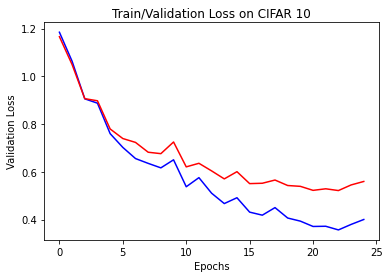

In [17]:
util.plot_loss(train_loss_vals,test_loss_vals,epochs)

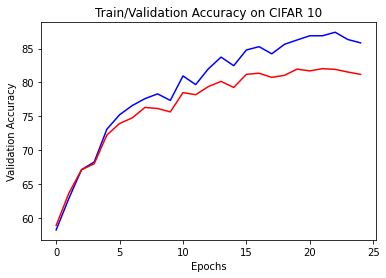

In [18]:
util.plot_acc(train_acc_vals,test_acc_vals,epochs)

## **Plot Misclassified Images and their predictions**

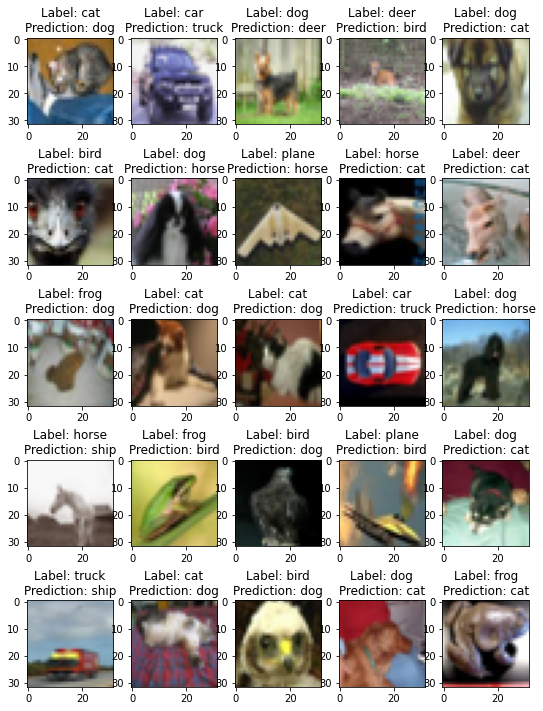

In [19]:
util.plot_misclassified(Net,"S7/models/S7_best_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)